In [ ]:
import copy
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from torchvision import models, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [ ]:
# exponential moving average
class EMA():
    def __init__(self, beta):
        self.beta = beta
        
    def __call__(self, ma, value):
        return self.beta * ma + (1 - self.beta) * value

In [ ]:
class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p

    def forward(self, x):
        if torch.rand(1) > self.p:
            return x
        else:
            return self.fn(x)

In [ ]:
class Hook():
    def __init__(self):
        self.output = None
        
    def set_hook(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.output = output
        
    def val(self):
        return self.output

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, proj_dim, hidden_dim=4096):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class NetWrapper(nn.Module):
    def __init__(self, net, proj_dim, proj_hidden_dim, embedding_layer=-2):
        super().__init__()
        self.projector = None
        self.net = net
        self.hook = Hook()
        self.proj_dim = proj_dim
        self.proj_hidden_dim = proj_hidden_dim
        self.hook.set_hook(self._get_layer(embedding_layer))

    def _get_layer(self, embedding_layer): # embedding_layer: int
        try:
            children = [*self.net.children()]
            return children[embedding_layer]
        except:
            print(f'layer-{embedding_layer} not found!!')

    def _get_projector(self, dim):
        return MLP(dim, self.proj_dim, self.proj_hidden_dim)
            
    def embed(self, x):
        _ = self.net(x)
        embedding = self.hook.val()
        embedding = embedding.reshape(embedding.shape[0], -1)
        return embedding
        
    def forward(self, x):
        embedding = self.embed(x)
        if self.projector is None:
            projector = self._get_projector(embedding.shape[1])
            self.projector = projector.to(embedding.device)
        projection = self.projector(embedding)
        return projection

In [ ]:
def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(-1)

In [ ]:
class BYOL(nn.Module):
    def __init__(self, net, img_size, loss_fn, embedding_layer=-2, proj_dim=256, proj_hidden_dim=4096, ema_decay=0.99):
        super().__init__()
        # SimCLR augmentation
        self.augmentation = nn.Sequential(
            RandomApply(
                T.ColorJitter(0.8, 0.8, 0.8, 0.2),
                p = 0.3
            ),
            T.RandomGrayscale(p=0.2),
            T.RandomHorizontalFlip(),
            RandomApply(
                T.GaussianBlur((3, 3), (1.0, 2.0)),
                p = 0.2
            ),
            T.RandomResizedCrop((img_size, img_size)),
            T.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406]),
                std=torch.tensor([0.229, 0.224, 0.225])),
        )
        self.loss_fn = loss_fn
        self.online_encoder = NetWrapper(net, proj_dim, proj_hidden_dim, embedding_layer)
        self.online_predictor = MLP(proj_dim, proj_dim, proj_hidden_dim)
        self.target_encoder = copy.deepcopy(self.online_encoder)
        self.target_ema = EMA(ema_decay)
    
    def update_target_encoder(self):
        for online_params, target_params in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_params.data = self.target_ema(ma=target_params.data, value=online_params.data)
    
    def learn(self, x):
        view1 = self.augmentation(x) 
        view2 = self.augmentation(x)

        online_proj1 = self.online_encoder(view1)
        online_proj2 = self.online_encoder(view2)
        online_pred1 = self.online_predictor(online_proj1)
        online_pred2 = self.online_predictor(online_proj2)
        
        with torch.no_grad():
            target_proj1 = self.target_encoder(view1)
            target_proj2 = self.target_encoder(view2)
            target_proj1 = target_proj1.detach()
            target_proj2 = target_proj2.detach()
        
        loss1 = self.loss_fn(online_pred1, target_proj2)
        loss2 = self.loss_fn(online_pred2, target_proj1)
        loss = loss1 + loss2    
        return loss.mean()
    
    def forward(self, x):
        return self.online_encoder.embed(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 5
update_every = 1
img_size = 256
batch_size = 64
lr = 3e-4
transform = T.Compose(
    [
     T.Resize((2*img_size, 2*img_size)),
     T.ToTensor()
    ]
)
print(device)

cuda


In [ ]:
data = datasets.CIFAR10("data/", train=False, download=True, transform=transform) # using val data
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
x, y = next(iter(loader))
print(len(data), x.shape, y.shape)

Files already downloaded and verified
10000 torch.Size([64, 3, 512, 512]) torch.Size([64])


In [ ]:
net = models.resnet18()
byol = BYOL(net=net, img_size=img_size, loss_fn=loss_fn).to(device)
optimizer = torch.optim.Adam(byol.parameters(), lr=lr)
inp = torch.randn(3, 3, 256, 256).to(device)
loss = byol.learn(inp)
embedding = byol(inp)
print(loss, embedding.shape)
del inp, loss, embedding

tensor(3.8927, device='cuda:0', grad_fn=<MeanBackward0>) torch.Size([3, 512])


In [ ]:
def loop(byol, loader, epoch, update_every):
    losses = []
    pbar = tqdm(loader, total=len(loader))
    for x, _ in pbar:
        x = x.to(device)
        loss = byol.learn(x)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % update_every == 0:
            byol.update_target_encoder()
        pbar.set_description(f'epoch={epoch}, avg_loss={np.mean(losses):.4f}')

In [ ]:
for epoch in range(n_epochs):
    loop(byol, loader, epoch, update_every)

epoch=4, avg_loss=0.8417: 100%|██████████| 157/157 [02:11<00:00,  1.20it/s]


torch.Size([3, 512, 512]) torch.Size([1, 512])


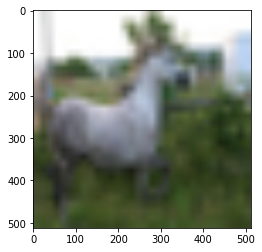

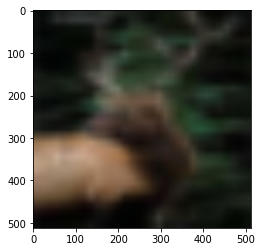

0.42596977949142456


In [ ]:
def plot_imgs(imgs):
    for img in imgs:
        plt.imshow(img.permute(1, 2, 0).cpu())
        plt.show()

img1, _ = data[69]
img2, _ = data[420]
img = img1.unsqueeze(0).to(device)
emb = byol(img)
print(img1.shape, emb.shape)

imgs = [img1, img2]
plot_imgs(imgs)
imgs = torch.stack(imgs).to(device)
loss = byol.learn(imgs)
print(loss.item())